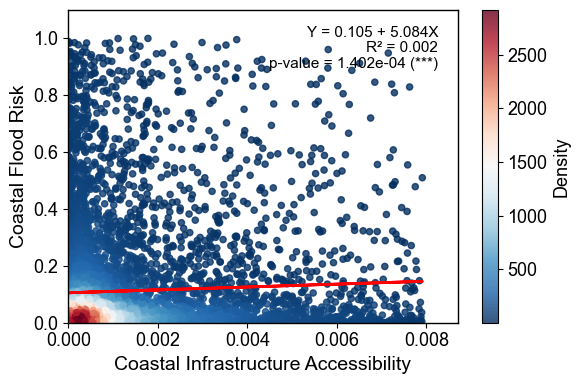

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler

# 设置全局字体和大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12  # 更小的字体以适应Nature审美
plt.rcParams['axes.titlesize'] = 13  # 更小的标题字体
plt.rcParams['axes.labelsize'] = 12  # 更小的轴标签字体
plt.rcParams['xtick.labelsize'] = 13  # 放大x轴标签字体
plt.rcParams['ytick.labelsize'] = 13  # 放大y轴标签字体
plt.rcParams['legend.fontsize'] = 12  # 更小的图例字体
plt.rcParams['figure.figsize'] = [6, 4]  # 调整图形大小

# 1. 读取数据
file_path = 'C:\\Users\\Dell\\Desktop\\Global Urban\\GID02_communities\\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# 2. 清理数据，确保 x 和 y 长度一致
x = df['Floods_2020_Vulnerability']  # 原本是纵坐标
y = df['Infra_Resilience_Index']  # 原本是横坐标
pop = df['Floods_2020_pop_GID02']
valid_mask = (x != 0) & (y != 0) & x.notna() & y.notna() & (pop > 0)
df_clean = df[valid_mask].copy()

# 删除 Infra_Resilience_Index 的异常值：使用 IQR 方法
Q1_resilience = df_clean['Infra_Resilience_Index'].quantile(0.25)
Q3_resilience = df_clean['Infra_Resilience_Index'].quantile(0.75)
IQR_resilience = Q3_resilience - Q1_resilience

# 定义异常值的范围
lower_bound_resilience = Q1_resilience - 1.5 * IQR_resilience
upper_bound_resilience = Q3_resilience + 1.5 * IQR_resilience

# 去除异常值
df_clean = df_clean[(df_clean['Infra_Resilience_Index'] >= lower_bound_resilience) & 
                    (df_clean['Infra_Resilience_Index'] <= upper_bound_resilience)]

# 3. 计算 IFVI
df_clean['IFVI'] = pop * x

# ================================
# 异常点去除：使用 IQR 方法
Q1 = df_clean['IFVI'].quantile(0.25)
Q3 = df_clean['IFVI'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常点的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常点
df_clean = df_clean[(df_clean['IFVI'] >= lower_bound) & (df_clean['IFVI'] <= upper_bound)]

# ================================
# 归一化：使用 MinMaxScaler
scaler = MinMaxScaler()
df_clean['Normalized_IFVI'] = scaler.fit_transform(df_clean[['IFVI']])

# ================================
# 使用 statsmodels 进行回归分析
X = sm.add_constant(df_clean['Infra_Resilience_Index'])  # 这里的 x 和 y 交换
y = df_clean['Normalized_IFVI']  # 使用归一化后的 IFVI

# 创建线性回归模型
model = sm.OLS(y, X).fit()  # OLS: 普通最小二乘回归

# 获取回归分析结果
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared
p_value = model.pvalues[1]  # 对应 Infra_Resilience_Index 的 p-value

# 根据 p-value 标注显著性
if p_value < 0.01:
    significance = '***'
elif p_value < 0.05:
    significance = '**'
elif p_value < 0.1:
    significance = '*'
else:
    significance = 'ns'  # 非显著

# ================================
# 计算每个点的密度
kde = gaussian_kde(np.vstack([df_clean['Infra_Resilience_Index'], df_clean['Normalized_IFVI']]))  # 使用清理后的数据
kde.set_bandwidth(bw_method='silverman')  # 设置带宽方法
density = kde(np.vstack([df_clean['Infra_Resilience_Index'], df_clean['Normalized_IFVI']]))  # 计算密度

# ================================
# 绘制散点图和趋势线
plt.figure(figsize=(6, 4))

# 绘制散点图，按照密度大小调整颜色
scatter = plt.scatter(df_clean['Infra_Resilience_Index'], df_clean['Normalized_IFVI'], 
                      c=density, cmap='RdBu_r', alpha=0.8, s=20)

# 绘制回归趋势线
y_pred = model.predict(X)
plt.plot(df_clean['Infra_Resilience_Index'], y_pred, color='red', linewidth=2)

# 设置回归方程和显著性信息
equation = f'Y = {intercept:.3f} + {slope:.3f}X'
r_squared_text = f'R² = {r_squared:.3f}'
p_value_text = f'p-value = {p_value:.3e} ({significance})'

# 添加回归方程和统计值到图上（放置右上角）
plt.text(0.95, 0.95, equation, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.95, 0.90, r_squared_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.95, 0.85, p_value_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')

# 设置图形属性
plt.xlabel('Coastal Infrastructure Accessibility', fontsize=14)  # 横坐标是 Infra_Resilience_Index
plt.ylabel('Coastal Flood Risk', fontsize=14)  # 纵坐标是归一化后的 IFVI

# 关闭网格线
plt.grid(False)

# 设置边框线颜色为黑色
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(1)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(1)

plt.gca().spines['left'].set_visible(True)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(1)

plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(1)

# 设置坐标轴范围从0开始
plt.xlim(0, df_clean['Infra_Resilience_Index'].max() * 1.1)  # 横坐标从0开始，并稍微扩展
plt.ylim(0, df_clean['Normalized_IFVI'].max() * 1.1)  # 纵坐标从0开始，并稍微扩展

# 添加颜色条
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Density', fontsize=13)

# 调整布局，避免文本遮挡
plt.tight_layout()

# 显示图形
plt.show()

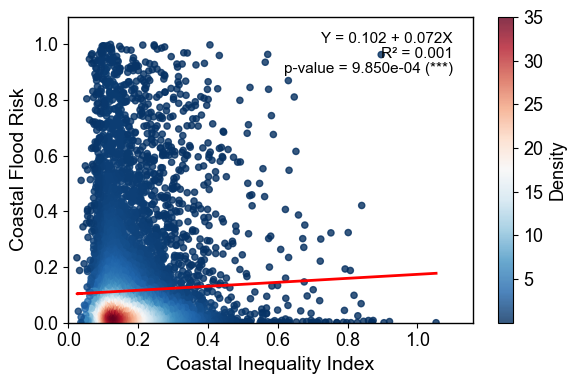

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler

# 设置全局字体和大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12  # 更小的字体以适应Nature审美
plt.rcParams['axes.titlesize'] = 13  # 更小的标题字体
plt.rcParams['axes.labelsize'] = 12  # 更小的轴标签字体
plt.rcParams['xtick.labelsize'] = 13  # 放大x轴标签字体
plt.rcParams['ytick.labelsize'] = 13  # 放大y轴标签字体
plt.rcParams['legend.fontsize'] = 12  # 更小的图例字体
plt.rcParams['figure.figsize'] = [6, 4]  # 调整图形大小

# 1. 读取数据
file_path = 'C:\\Users\\Dell\\Desktop\\Global Urban\\GID02_communities\\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# 2. 清理数据，确保 x 和 y 长度一致
x = df['Floods_2020_Vulnerability']  # 原本是纵坐标
y = df['Inequality']  # 原本是横坐标
pop = df['Floods_2020_pop_GID02']
valid_mask = (x != 0) & (y != 0) & x.notna() & y.notna() & (pop > 0)
df_clean = df[valid_mask].copy()

# 检查 x 和 y 的长度是否一致
assert len(x) == len(y), "x 和 y 的长度不一致"

# 3. 计算 IFVI
df_clean['IFVI'] = pop * x

# ================================
# 异常点去除：使用 IQR 方法
Q1 = df_clean['IFVI'].quantile(0.25)
Q3 = df_clean['IFVI'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常点的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常点
df_clean = df_clean[(df_clean['IFVI'] >= lower_bound) & (df_clean['IFVI'] <= upper_bound)]

# ================================
# 归一化：使用 MinMaxScaler
scaler = MinMaxScaler()
df_clean['Normalized_IFVI'] = scaler.fit_transform(df_clean[['IFVI']])

# ================================
# 使用 statsmodels 进行回归分析
X = sm.add_constant(df_clean['Inequality'])  # 这里的 x 和 y 交换
y = df_clean['Normalized_IFVI']  # 使用归一化后的 IFVI

# 创建线性回归模型
model = sm.OLS(y, X).fit()  # OLS: 普通最小二乘回归

# 获取回归分析结果
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared
p_value = model.pvalues[1]  # 对应 Inequality 的 p-value

# 根据 p-value 标注显著性
if p_value < 0.01:
    significance = '***'
elif p_value < 0.05:
    significance = '**'
elif p_value < 0.1:
    significance = '*'
else:
    significance = 'ns'  # 非显著

# ================================
# 计算每个点的密度
kde = gaussian_kde(np.vstack([df_clean['Inequality'], df_clean['Normalized_IFVI']]))  # 使用清理后的数据
kde.set_bandwidth(bw_method='silverman')  # 设置带宽方法
density = kde(np.vstack([df_clean['Inequality'], df_clean['Normalized_IFVI']]))  # 计算密度

# ================================
# 绘制散点图和趋势线
plt.figure(figsize=(6, 4))

# 绘制散点图，按照密度大小调整颜色
scatter = plt.scatter(df_clean['Inequality'], df_clean['Normalized_IFVI'], 
                      c=density, cmap='RdBu_r', alpha=0.8, s=20)

# 绘制回归趋势线
y_pred = model.predict(X)
plt.plot(df_clean['Inequality'], y_pred, color='red', linewidth=2)

# 设置回归方程和显著性信息
equation = f'Y = {intercept:.3f} + {slope:.3f}X'
r_squared_text = f'R² = {r_squared:.3f}'
p_value_text = f'p-value = {p_value:.3e} ({significance})'

# 添加回归方程和统计值到图上（放置右上角）
plt.text(0.95, 0.95, equation, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.95, 0.90, r_squared_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')
plt.text(0.95, 0.85, p_value_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=11, color='black')

# 设置图形属性
plt.xlabel('Coastal Inequality Index', fontsize=14)  # 横坐标是 Inequality
plt.ylabel('Coastal Flood Risk', fontsize=14)  # 纵坐标是归一化后的 IFVI

# 关闭网格线
plt.grid(False)

# 设置边框线颜色为黑色
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(1)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(1)

plt.gca().spines['left'].set_visible(True)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(1)

plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(1)

# 设置坐标轴范围从0开始
plt.xlim(0, df_clean['Inequality'].max() * 1.1)  # 横坐标从0开始，并稍微扩展
plt.ylim(0, df_clean['Normalized_IFVI'].max() * 1.1)  # 纵坐标从0开始，并稍微扩展

# 添加颜色条
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Density', fontsize=13)

# 调整布局，避免文本遮挡
plt.tight_layout()

# 显示图形
plt.show()